**<h1 align="center">Model Creation Notebook</h1>**

<p align="center"><i>Use this Notebook to experiment with model creation</i></p>

## Global variables

### Global variables

Project specific variables

In [1]:
IMG_SIZE = 128  # Resize all images to 128x128
BATCH_SIZE = 32

SPLIT_SIZE = 0.9

# Specify the directory where the dataset will be stored
DATA_DIR = 'src/static/data'

MODEL_DIR = "src/static/model/"
# MODEL_NAME = 'model.keras'
MODEL_NAME = 'new_model.keras'
MODEL_PATH = MODEL_DIR + MODEL_NAME

Colors

In [2]:
# ANSI escape codes for colored output
GREEN = "\033[92m"
BLUE = "\033[94m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"  # White

### Python Imports

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report


import math

## Import Data

### Import Data

In [4]:
# Load the Malaria dataset
print(f"\n{YELLOW}Loading dataset...{RESET}")
dataset, info = tfds.load('malaria', as_supervised=True, with_info=True, data_dir=DATA_DIR)


Loading dataset...


In [5]:
# Get the total number of samples
total_samples = info.splits['train'].num_examples
print(f"\n{BLUE}Total samples:{RESET} {total_samples}")


Total samples: 27558


In [6]:
# Calculate split sizes
train_size = int(SPLIT_SIZE * total_samples)
test_size = total_samples - train_size
print(f"\n{BLUE}Train size:{RESET} {train_size}")
print(f"{BLUE}Test size:{RESET} {test_size}")

# Split the dataset into training and testing sets
train_dataset = dataset['train'].take(train_size)
test_dataset = dataset['train'].skip(train_size)


Train size: 24802
Test size: 2756


## Display random samples

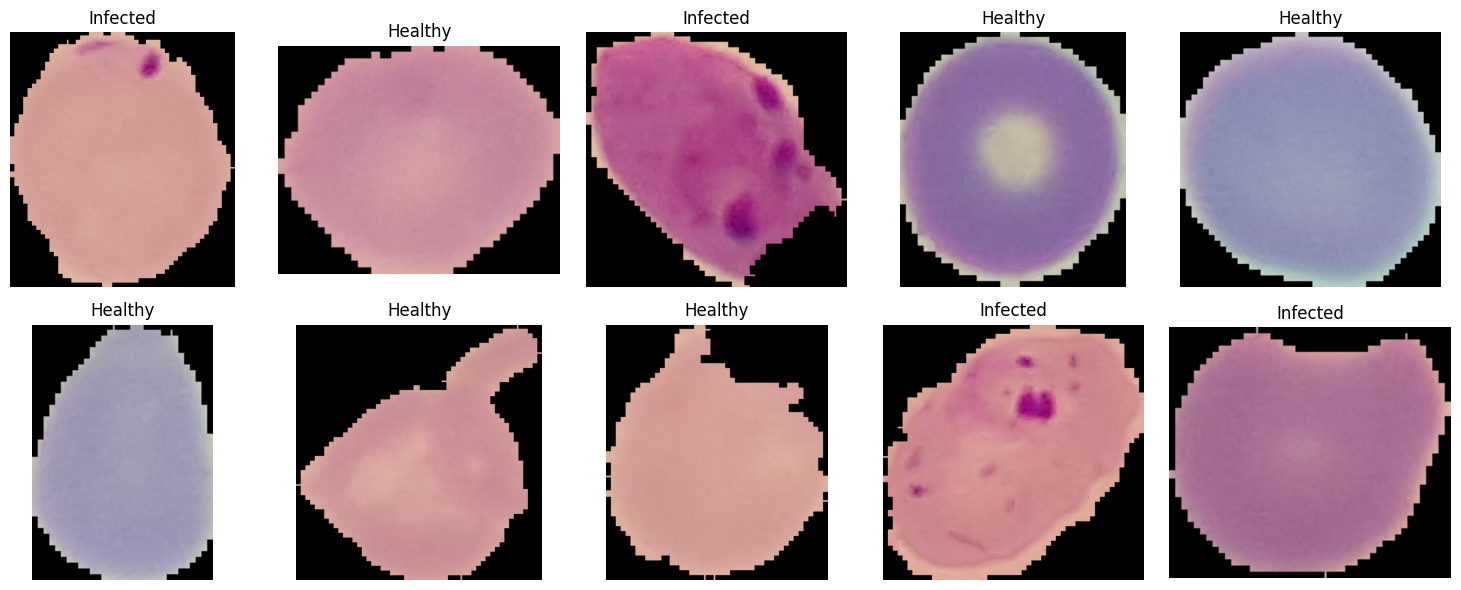

In [7]:
def display_samples(data, nb_columns, nb_rows):
    """
    Display a grid of random samples from the dataset along with their labels.
    
    Parameters:
        data (tf.data.Dataset): The dataset to sample from.
        nb_columns (int): Number of samples per row.
        nb_rows (int): Number of samples per column.
    """
    # Prepare the figure
    plt.figure(figsize=(nb_columns * 3, nb_rows * 3))
    
    # Get random samples from the dataset
    samples = data.shuffle(1000).take(nb_columns * nb_rows)
    
    # Loop through the grid
    for idx, (image, label) in enumerate(samples):
        if idx >= nb_columns * nb_rows:
            break  # Ensure we don't exceed the grid size
        
        plt.subplot(nb_rows, nb_columns, idx + 1)
        plt.imshow(image.numpy())  # Convert TensorFlow tensor to numpy array
        plt.title("Healthy" if label.numpy() == 1 else "Infected")
        plt.axis('off')  # Remove axis for better visualization

    plt.tight_layout()
    plt.show()

# Display grid of samples from the training dataset
display_samples(train_dataset, nb_columns=5, nb_rows=2)

## Preprocessing

In [8]:
def preprocess(image, label):
        # Resize the image and normalize pixel values
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image / 255.0  # Normalize to [0, 1]
        return image, label

In [9]:
# Apply preprocessing and batching
print(f"\n{YELLOW}Preprocessing and batching...{RESET}")
train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).shuffle(1000)
test_dataset = test_dataset.map(preprocess).batch(BATCH_SIZE)


Preprocessing and batching...


## Model Setup

In [10]:
# Define a CNN model
model = models.Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),  # Define the input shape explicitly
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.5),  # Add dropout after the first MaxPooling layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.5),  # Add dropout after the second MaxPooling layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.5),  # Add dropout before the final dense layer
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [11]:
# Compile the model
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [12]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',    # Surveille la perte de validation
    patience=3,            # Arrête l’entraînement après 3 epochs sans amélioration
    restore_best_weights=True  # Restaure les poids du meilleur modèle
)

## Model Training

In [13]:
# Train the model
print(f"\n{YELLOW}Training model...{RESET}")
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)


Training model...
Epoch 1/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 255s 317ms/step - accuracy: 0.7030 - loss: 0.6451 - val_accuracy: 0.8843 - val_loss: 0.3133
Epoch 2/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 252s 318ms/step - accuracy: 0.9223 - loss: 0.2688 - val_accuracy: 0.9398 - val_loss: 0.1968
Epoch 3/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 246s 310ms/step - accuracy: 0.9352 - loss: 0.2242 - val_accuracy: 0.9354 - val_loss: 0.1945
Epoch 4/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 288s 364ms/step - accuracy: 0.9404 - loss: 0.1952 - val_accuracy: 0.9369 - val_loss: 0.1885
Epoch 5/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 247s 312ms/step - accuracy: 0.9430 - loss: 0.1885 - val_accuracy: 0.9419 - val_loss: 0.2045
Epoch 6/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 264s 332ms/step - accuracy: 0.9458 - loss: 0.1754 - val_accuracy: 0.9456 - val_loss: 0.1721
Epoch 7/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 257s 325ms/step - accuracy: 0.9501 - loss: 0.1577 - val_accuracy: 0.9441 - val_loss: 0.1706
Epoch 8/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 257s 325ms/step -

## Saving Model

In [14]:
# Save the model
print(f"\n{YELLOW}Saving model to:{RESET} {MODEL_PATH}")
model.save(MODEL_PATH)


Saving model to: src/static/model/new_model.keras


## Model Evaluation

In [15]:
# Evaluate the model on the test dataset
print(f"\n{YELLOW}Evaluating model...{RESET}")
y_true = []
y_pred = []
wrong_predictions = []

for images, labels in test_dataset:
    # Get true labels
    true_labels = labels.numpy()
    # Get predicted probabilities
    pred_probs = model.predict(images).flatten()  # Flatten the array for easier processing

    # Convert probabilities to binary predictions
    pred_labels = (pred_probs > 0.5).astype(int)

    # Append results
    y_true.extend(true_labels)
    y_pred.extend(pred_labels)

    # Log wrong predictions
    for i in range(len(true_labels)):
        if true_labels[i] != pred_labels[i]:
            confidence = pred_probs[i] if pred_labels[i] == 1 else 1 - pred_probs[i]  # Confidence for predicted class
            wrong_predictions.append({
                "image": images[i].numpy(),  # Include the image
                "real_label": "Healthy" if true_labels[i] == 1 else "Infected",  # Map label to string
                "pred_label": "Healthy" if pred_labels[i] == 1 else "Infected",  # Map label to string
                "probability": confidence  # Include the confidence probability
            })

# Convert to NumPy arrays for metrics
y_true = np.array(y_true)
y_pred = np.array(y_pred)


Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

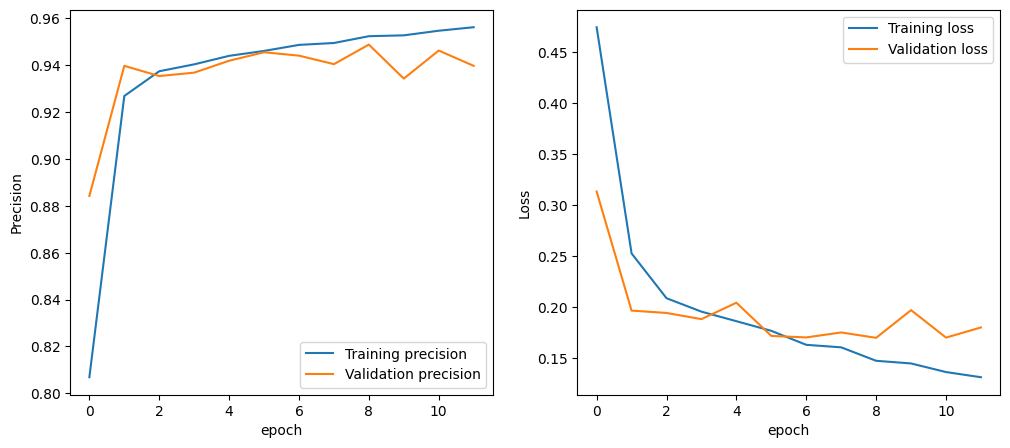

In [16]:
def plot_precision_and_loss(history):
    # Display precision
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)  # First subplot on the left
    plt.plot(history.history['accuracy'], label="Training precision")
    plt.plot(history.history['val_accuracy'], label="Validation precision")
    plt.xlabel("epoch")
    plt.ylabel("Precision")
    plt.legend()

    # Display loss
    plt.subplot(1, 2, 2)  # Second subplot on the right
    plt.plot(history.history['loss'], label="Training loss")
    plt.plot(history.history['val_loss'], label="Validation loss")
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()
    
plot_precision_and_loss(history)


Confusion Matrix:
[[1291  102]
 [  39 1324]]


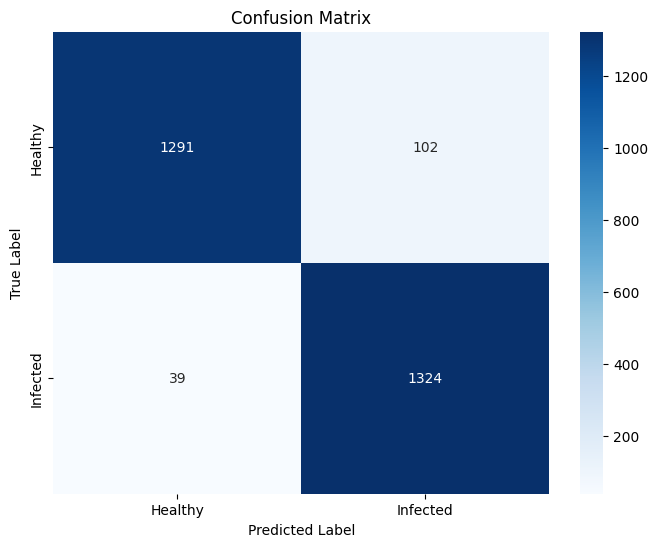

In [17]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(f"\n{BLUE}Confusion Matrix:{RESET}")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Infected'], 
            yticklabels=['Healthy', 'Infected'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Generate classification report
print(f"\n{BLUE}Classification Report:{RESET}")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Infected']))


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.97      0.93      0.95      1393
    Infected       0.93      0.97      0.95      1363

    accuracy                           0.95      2756
   macro avg       0.95      0.95      0.95      2756
weighted avg       0.95      0.95      0.95      2756



## Wrong Predictions

In [19]:
# Display wrong predictions
if wrong_predictions:
    print(f"\n{RED}Wrong Predictions:{RESET}")
    wrong_df = pd.DataFrame(wrong_predictions)
    display(wrong_df)
else:
    print(f"\n{GREEN}No wrong predictions!{RESET}")


Wrong Predictions:


,image,real_label,pred_label,probability
0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",Infected,Healthy,0.767053
1,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",Infected,Healthy,0.533814
2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",Infected,Healthy,0.905230
3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",Infected,Healthy,0.945916
4,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",Healthy,Infected,0.986309
...,...,...,...,...
136,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",Healthy,Infected,0.883617
137,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",Healthy,Infected,0.612293
138,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",Healthy,Infected,0.558491
139,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",Infected,Healthy,0.606218


Healthy:


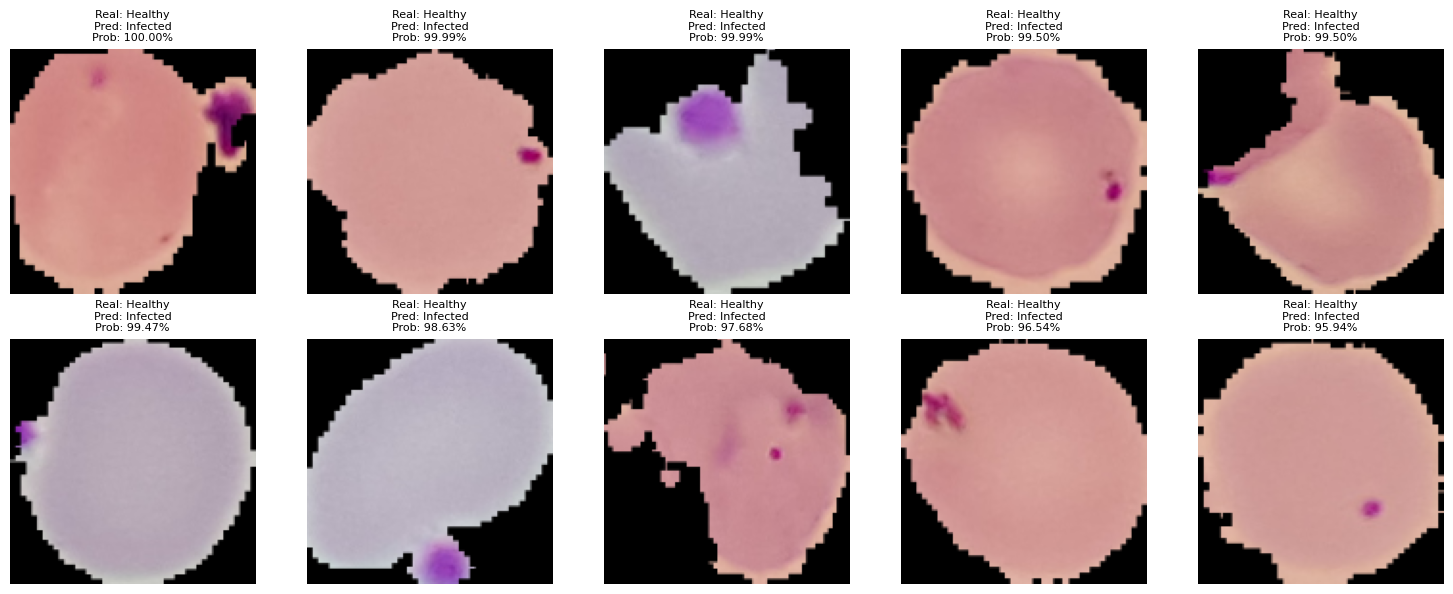

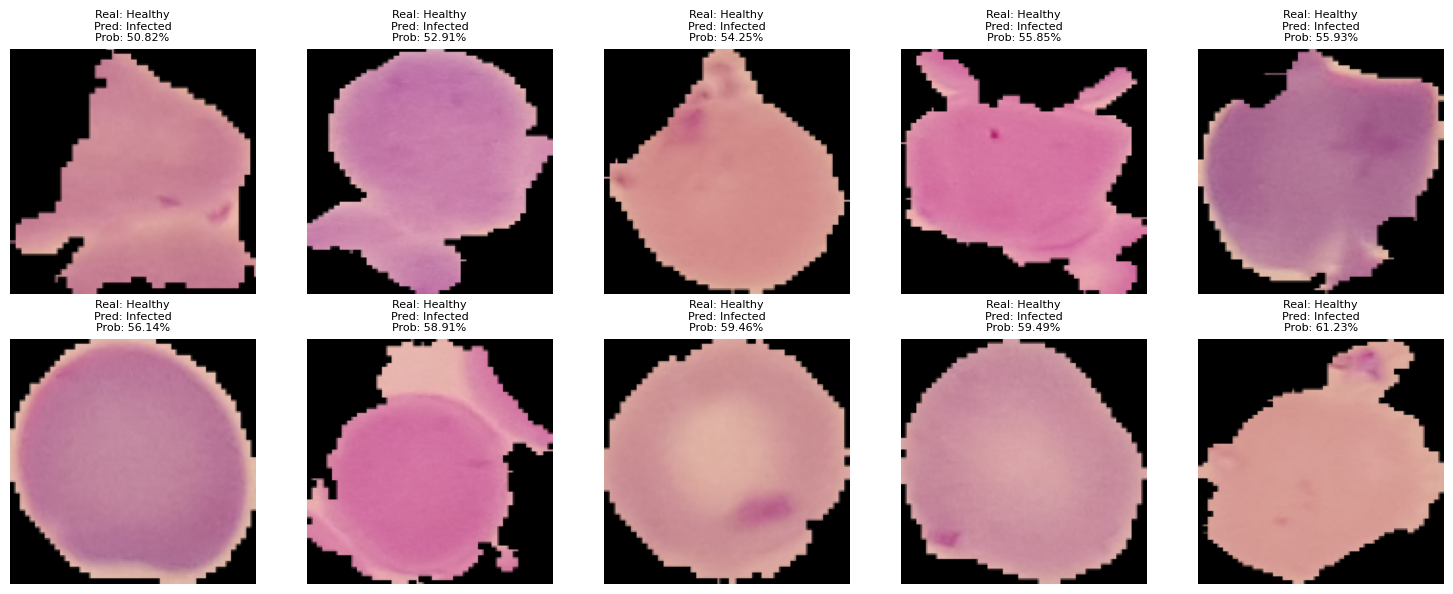

Infected:


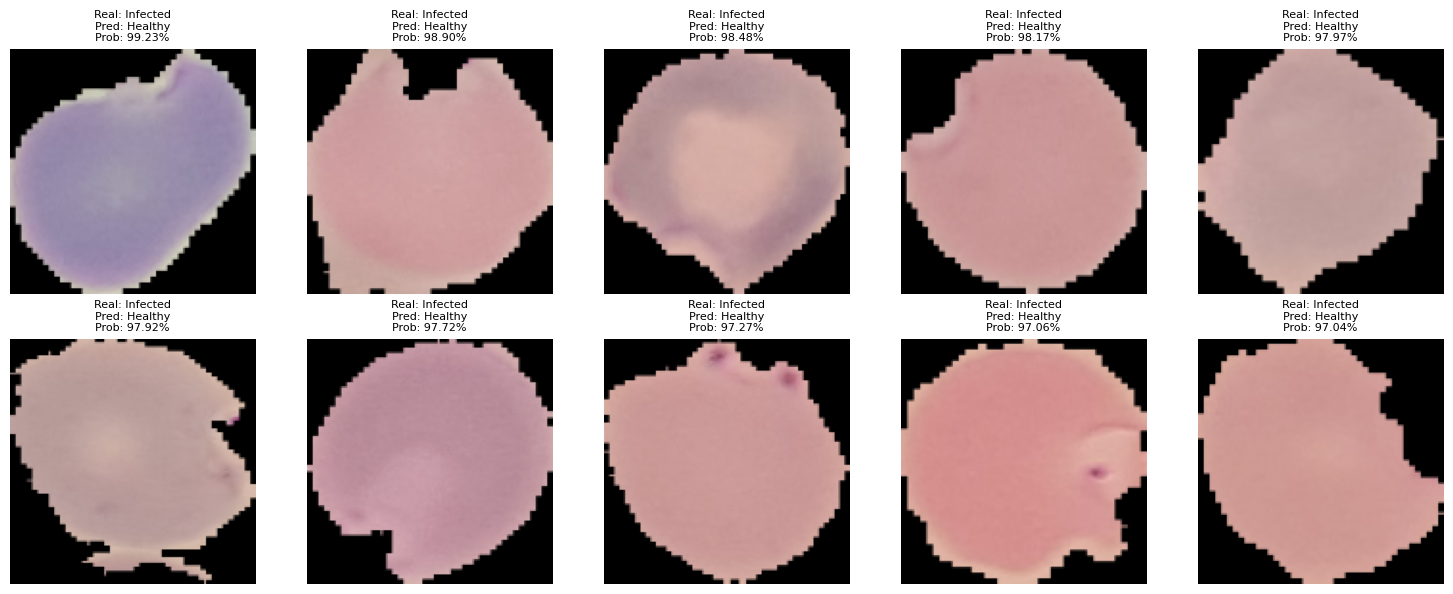

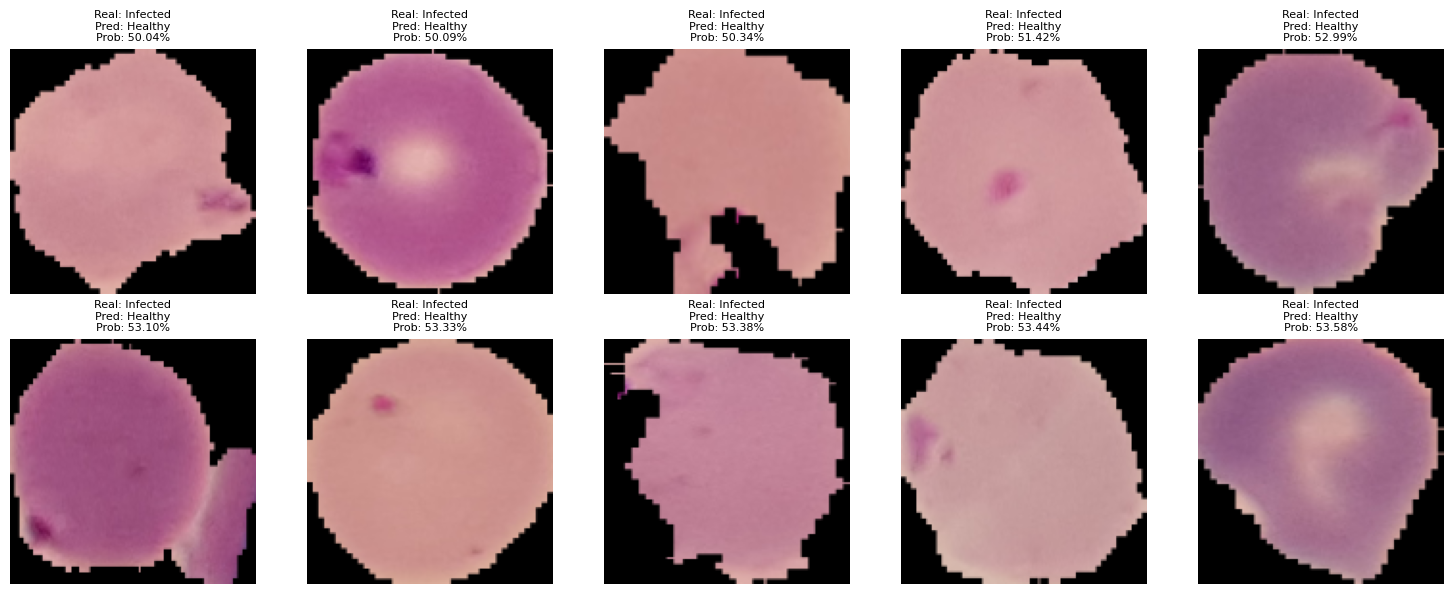

In [20]:
def display_wrong_predictions(wrong_predictions, nb_columns, nb_rows, order='desc', label='All'):
    """
    Display wrong predictions as images with real label, predicted label, and predicted probability.

    Parameters:
        wrong_predictions (list): List of dictionaries containing wrong prediction data. Each dictionary
                                  should have keys 'image', 'real_label', 'pred_label', 'probability'.
        nb_columns (int): Number of images per row.
        nb_rows (int): Number of images per column.
        order (str): 'asc' for ascending or 'desc' for descending order of probabilities.
        label (str): Filter by real label ('Healthy', 'Infected', or 'All').
    """
    # Convert wrong predictions to DataFrame
    wrong_df = pd.DataFrame(wrong_predictions)
    
    # Filter by label if specified
    if label != 'All':
        wrong_df = wrong_df[wrong_df['real_label'] == label]

    # Sort by probability
    if order == 'asc':
        wrong_df = wrong_df.sort_values(by='probability')
    elif order == 'desc':
        wrong_df = wrong_df.sort_values(by='probability', ascending=False)
    
    # Limit to the number of images requested
    max_images = nb_columns * nb_rows
    wrong_df = wrong_df.head(max_images)

    # Prepare the figure
    plt.figure(figsize=(nb_columns * 3, nb_rows * 3))

    for idx, row in enumerate(wrong_df.itertuples()):
        if idx >= max_images:
            break  # Stop if we have reached the grid limit

        # Get the image and metadata
        image = row.image
        real_label = row.real_label
        pred_label = row.pred_label
        probability = row.probability

        # Plot the image
        plt.subplot(nb_rows, nb_columns, idx + 1)
        plt.imshow(image)
        plt.title(
            f"Real: {real_label}\nPred: {pred_label}\nProb: {probability * 100:.2f}%",
            fontsize=8
        )
        plt.axis('off')  # Remove axis for clarity

    plt.tight_layout()
    plt.show()

print(f"{YELLOW}Healthy:{RESET}")
display_wrong_predictions(wrong_predictions, nb_columns=5, nb_rows=2, order='desc', label='Healthy')
display_wrong_predictions(wrong_predictions, nb_columns=5, nb_rows=2, order='asc', label='Healthy')

print(f"{YELLOW}Infected:{RESET}")
display_wrong_predictions(wrong_predictions, nb_columns=5, nb_rows=2, order='desc', label='Infected')
display_wrong_predictions(wrong_predictions, nb_columns=5, nb_rows=2, order='asc', label='Infected')